In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


def BuildModel_SegNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_SegNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

In [2]:
def BuildModel_UNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conc_1 = Concatenate()([conv_3_2, up_1])
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_2_2, up_2])
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_1_2, up_3])
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_UNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

In [3]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		40
Number of files in Validation-set:	8


img_df = data.train.image_paths
mask_df = data.train.masks_paths
batch_size = 26

index = 0
while index < 5:
    x_batch = []
    y_batch = []
    r_batch = []

    for i in range(batch_size):
        img_name = img_df[index]
        mask_name = mask_df[index]

#             print(index, img_name, mask_name)

        index = (index + 1) % len(img_df)

        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

#             img, mask

        img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
        mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

        height, width = mask.shape
        masks = np.zeros((height, width, 4))
        for i in range(masks.shape[2]):
            masks[:, :, i] = (mask == (i+1))

        #moving the channel:
        mask_train = np.moveaxis(masks,-1,1)

        x_batch += [img]
        y_batch.append(mask_train)
        r_batch += [mask]

    x_batch = np.array(x_batch) / 255.
    y_batch = np.array(y_batch) / 255.
    r_batch = np.array(r_batch) / 255.

x_batch.shape,y_batch.shape,r_batch.shape

In [44]:
def read_image_with_mask(img_name, mask_name):
    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            
#     img, mask
            
    img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
    mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

    height, width = mask.shape
    masks = np.zeros((height, width, 4))
    for i in range(masks.shape[2]):
        masks[:, :, i] = (mask == (i+1))
            
#     masks = np.moveaxis(masks,-1,1)

    return img / 255., masks / 1.

def prepare_image_and_mask_for_prediction(img_name, mask_name):
    img, masks = read_image_with_mask(img_name, mask_name)
    return np.array([img]), np.array([masks])

def keras_generator(img_df, mask_df, batch_size):
    index = 0
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name = img_df[index]
            mask_name = mask_df[index]
            
#             print(index, img_name, mask_name)
            
            index = (index + 1) % len(img_df)
            
            img, masks = read_image_with_mask(img_name, mask_name)
            
            x_batch += [img]
            y_batch.append(masks)

        
#         print(x_batch.shape,y_batch.shape)

        yield np.array(x_batch), np.array(y_batch)

In [6]:
batch_size = 16
model.fit_generator(keras_generator(data.train.image_paths, data.train.masks_paths, batch_size),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
5/5 [==============================] - 162s 32s/step - loss: 1.3875 - val_loss: 1.3680
Epoch 2/3
5/5 [==============================] - 160s 32s/step - loss: 1.3390 - val_loss: 1.2511
Epoch 3/3
5/5 [==============================] - 160s 32s/step - loss: 1.0897 - val_loss: 0.6606


from keras.models import load_model

model1 = BuildModel_SegNet()
model1.load_weights('unet_best.h5')
# model1 = load_model('unet_best.h5')

In [112]:
from keras.models import load_model
model1 = load_model('segnet_best.h5')
# model1 = load_model('unet_best.h5')

In [180]:
for x, y in keras_generator(data.valid.image_paths, data.valid.masks_paths, 16):
    break

In [181]:
pred = model1.predict(x)

In [182]:
def getClassesMap(pred):
    res = np.zeros((pred.shape[0], pred.shape[1]), np.uint8)
    for r in range(pred.shape[0]):
        for c in range(pred.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            res[r,c] = pred_class_index
    res.shape
    return res

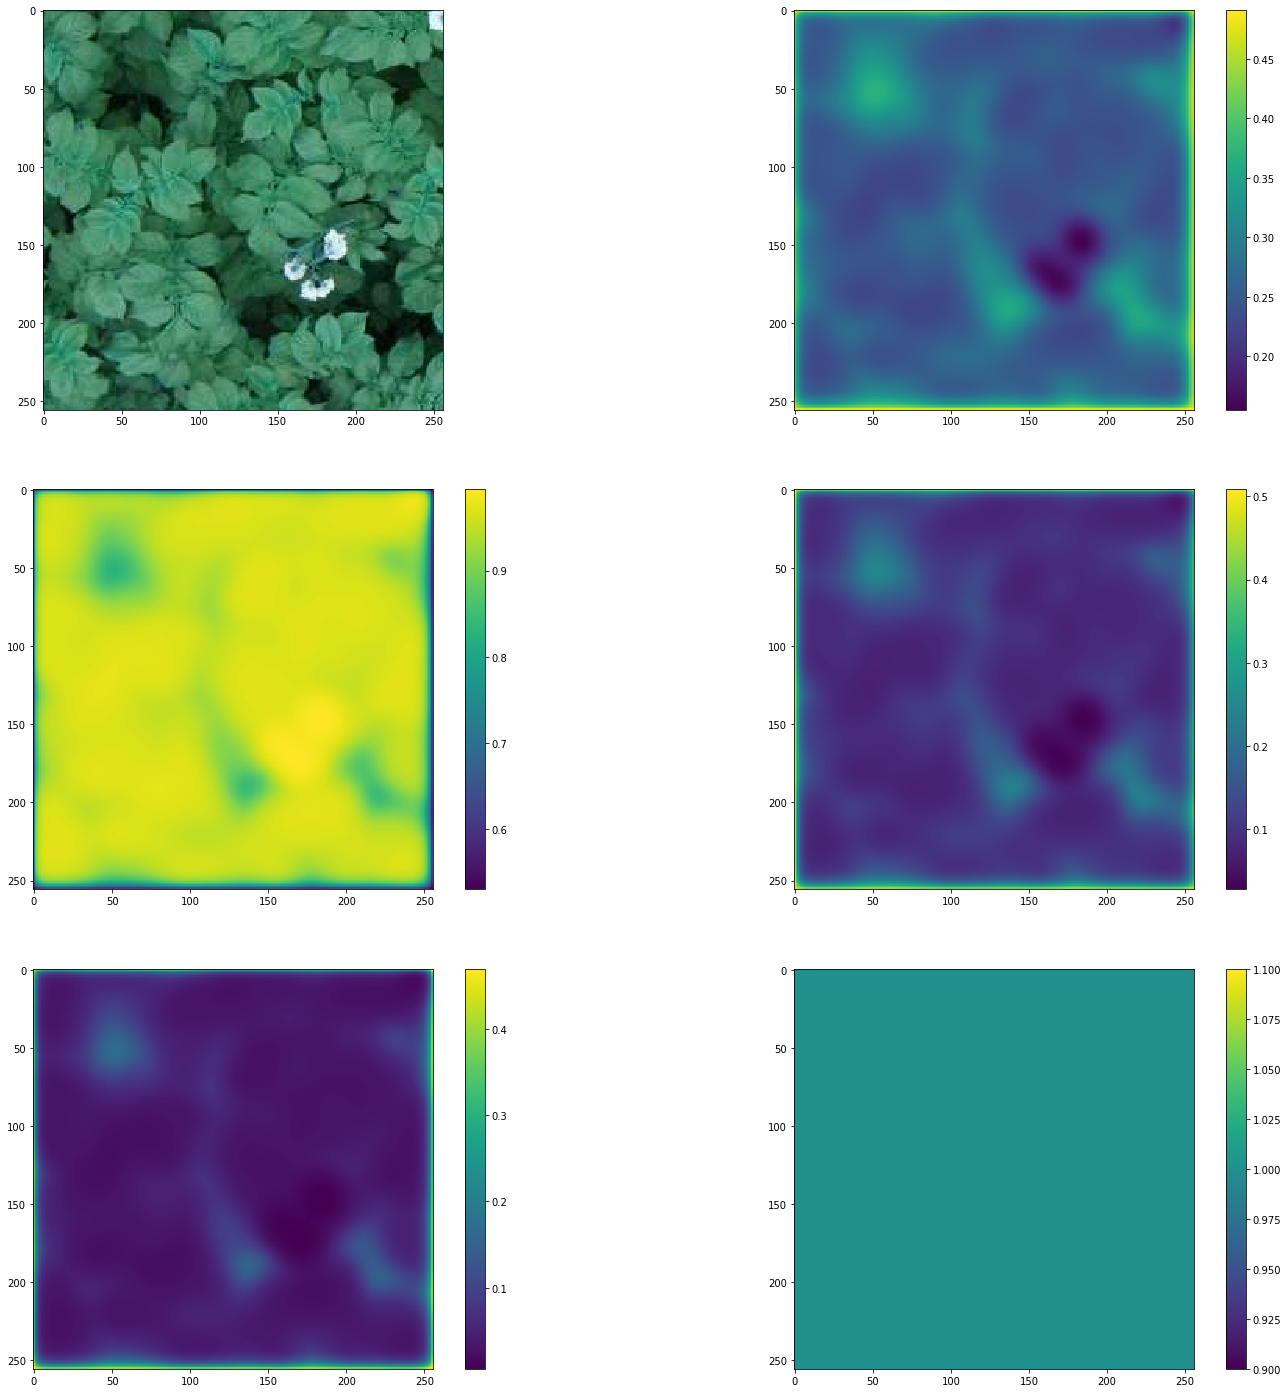

In [200]:
sample_index = 10
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index])
im_0_1 = axes[0][1].imshow(pred[sample_index, ..., 0])
im_1_0 = axes[1][0].imshow(pred[sample_index, ..., 1])
im_1_1 = axes[1][1].imshow(pred[sample_index, ..., 2])
im_2_0 = axes[2][0].imshow(pred[sample_index, ..., 3])
# im_2_1 = axes[2][1].imshow(keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)).astype(np.float32))
im_2_1 = axes[2][1].imshow(getClassesMap(pred[sample_index]))
# im_2_1 = axes[2][1].imshow(pred[sample_index, 20:40, 0:5, 0])

plt.colorbar(im_0_1, ax=axes[0,1])
plt.colorbar(im_1_0, ax=axes[1,0])
plt.colorbar(im_1_1, ax=axes[1,1])
plt.colorbar(im_2_0, ax=axes[2,0])
plt.colorbar(im_2_1, ax=axes[2,1])

plt.show()

In [184]:
def CountErrors(y, pred):
    ok_cnt = 0
    valid = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    errors = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    
    for r in range(y.shape[0]):
        for c in range(y.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            real_class_index = np.argmax(y[r,c,:])
            if pred_class_index not in [0,1,2,3] or real_class_index not in [0,1,2,3]:
                print(r,c,pred_class_index, real_class_index)
                continue
#             print(r,c,pred_class_index, real_class_index)
            if pred_class_index == real_class_index:
                ok_cnt = ok_cnt + 1
                valid[real_class_index][pred_class_index] += 1
            else:
                errors[real_class_index][pred_class_index] += 1
    return ok_cnt, valid, errors

In [189]:
sample_index = 2

ok_cnt, valid, errors = CountErrors(y[sample_index], pred[sample_index])       

In [190]:
ok_cnt, valid, errors

(65536,
 {0: [0, 0, 0, 0], 1: [0, 65536, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 0, 0, 0], 1: [0, 0, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]})

### Image by image segmentation

In [201]:
img_name = './validation/sample_2.png'
mask_name = './validation/sample_2_mask.png'
x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)

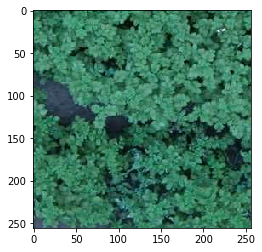

In [203]:
plt.imshow(x[0])

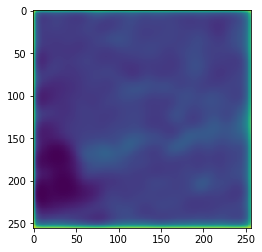

In [204]:
plt.imshow(pred[0, ..., 2])

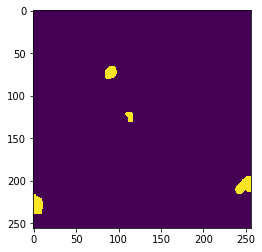

In [205]:
plt.imshow(y[0, ..., 2])

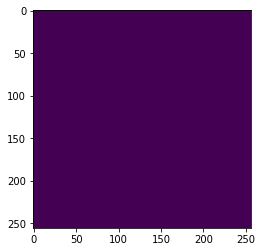

In [206]:
plt.imshow(getClassesMap(pred[0]))

In [209]:
sum(sum(getClassesMap(pred)))

27212

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0,0].imshow(x[0])
im_0_1 = axes[0][1].imshow(pred[0, ..., 0])

plt.colorbar(im_0_1, ax=axes[0,1])

In [211]:
pred = model1.predict(x)

In [213]:
ok_cnt, valid, errors = CountErrors(y[0], pred[0]) 

In [214]:
ok_cnt, valid, errors

(60806,
 {0: [0, 0, 0, 0], 1: [0, 60806, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 3947, 0, 0], 1: [0, 0, 0, 0], 2: [0, 783, 0, 0], 3: [0, 0, 0, 0]})

### Estimate accuracy for validation set

In [215]:
all_ok_cnt = 0
all_valid = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}
all_errors = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}

for i in range(len(data.valid.image_paths)):
    img_name = data.valid.image_paths[i]
    mask_name = data.valid.masks_paths[i]
    
    x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)
    
    pred = model1.predict(x)
    
    ok_cnt, valid, errors = CountErrors(y[0], pred[0]) 
    
    all_ok_cnt += ok_cnt
    for j in range(4):
        all_valid[j] = [x + y for x, y in zip(all_valid[j], valid[j])]
        all_errors[j] = [x + y for x, y in zip(all_errors[j], errors[j])]

image_area = params.GetImageSize() * params.GetImageSize()
image_cnt = len(data.valid.image_paths)
scale = float(image_area * image_cnt) / 100.

all_ok_cnt /= scale
for j in range(4):
    all_valid[j] = [x / scale for x in all_valid[j]]
    all_errors[j] = [x / scale for x in all_errors[j]]

In [216]:
all_ok_cnt, all_valid, all_errors

(91.40567779541016,
 {0: [0.0, 0.0, 0.0, 0.0],
  1: [0.0, 91.40567779541016, 0.0, 0.0],
  2: [0.0, 0.0, 0.0, 0.0],
  3: [0.0, 0.0, 0.0, 0.0]},
 {0: [0.0, 6.3045501708984375, 0.0, 0.0],
  1: [0.0, 0.0, 0.0, 0.0],
  2: [0.0, 1.5987396240234375, 0.0, 0.0],
  3: [0.0, 0.6910324096679688, 0.0, 0.0]})